# RESILIENT MACHINE LEARNING-BASED FORECASTING OF ELECTRICITY DEMAND IN THE CONTEXT OF CLIMATE CHANGE. A CASE STUDY OF THE DYNAMIC WEATHER PATTERNS OF THE NORDIC COUNTRIES.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.stats.diagnostic as diagnostic
import statsmodels.tools.eval_measures as eval_measures
import statsmodels.tsa.vector_ar.var_model as var_model
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
import shap
import lime
import hyperopt
import joblib
from tqdm import tqdm
import mlxtend
import json
from libtad import HolidaysService
from libtad.datatypes.holidays import HolidayType

In [2]:
df = pd.read_csv("nordicload.csv")

In [3]:
df.describe()

,Total Load [MW] - Norway,Total Load [MW] - Sweden,Total Load [MW] - Finland,Temp - Norway,Temp - Sweden,Temp - Finland
count,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000,5113.000000
mean,14975.997262,15673.575396,9480.257188,4.625361,7.003264,5.398611
std,3066.915246,3059.925444,1480.318052,8.894033,8.369215,9.321126
min,9414.000000,9982.000000,5863.000000,-24.020000,-18.950000,-26.350000
25%,12201.000000,13242.000000,8271.000000,-1.710000,0.550000,-0.950000
50%,14692.000000,15273.000000,9319.000000,4.520000,6.450000,4.930000
75%,17565.000000,18015.000000,10529.000000,12.600000,14.310000,13.510000
max,27553.000000,24420.000000,14298.000000,23.940000,26.110000,25.460000


In [4]:
df

,Load Date,Total Load [MW] - Norway,Total Load [MW] - Sweden,Total Load [MW] - Finland,Temp - Norway,Temp - Sweden,Temp - Finland
0,1/1/2010,19067,19703,11427,-11.30,-7.62,-15.11
1,1/2/2010,19566,20316,12129,-15.99,-9.00,-19.03
2,1/3/2010,19531,20844,11925,-14.84,-12.53,-15.06
3,1/4/2010,20426,21913,12250,-12.64,-12.80,-7.33
4,1/5/2010,21402,23337,12726,-19.60,-16.35,-13.74
...,...,...,...,...,...,...,...
5108,12/27/2023,20125,18863,10688,-8.08,-8.57,-7.20
5109,12/28/2023,20151,18044,10976,-8.64,-3.80,-4.25
5110,12/29/2023,19551,17388,11279,-8.05,-0.20,-2.93
5111,12/30/2023,19033,17182,11327,-7.72,-1.63,-7.31


In [5]:
# First, let's convert the 'Load Date' in nordic_load to datetime for merging purposes
df['Load Date'] = pd.to_datetime(df['Load Date'], format='%m/%d/%Y')

# Extract year from 'Load Date' for merging
df['Year'] = df['Load Date'].dt.year
df

,Load Date,Total Load [MW] - Norway,Total Load [MW] - Sweden,Total Load [MW] - Finland,Temp - Norway,Temp - Sweden,Temp - Finland,Year
0,2010-01-01,19067,19703,11427,-11.30,-7.62,-15.11,2010
1,2010-01-02,19566,20316,12129,-15.99,-9.00,-19.03,2010
2,2010-01-03,19531,20844,11925,-14.84,-12.53,-15.06,2010
3,2010-01-04,20426,21913,12250,-12.64,-12.80,-7.33,2010
4,2010-01-05,21402,23337,12726,-19.60,-16.35,-13.74,2010
...,...,...,...,...,...,...,...,...
5108,2023-12-27,20125,18863,10688,-8.08,-8.57,-7.20,2023
5109,2023-12-28,20151,18044,10976,-8.64,-3.80,-4.25,2023
5110,2023-12-29,19551,17388,11279,-8.05,-0.20,-2.93,2023
5111,2023-12-30,19033,17182,11327,-7.72,-1.63,-7.31,2023


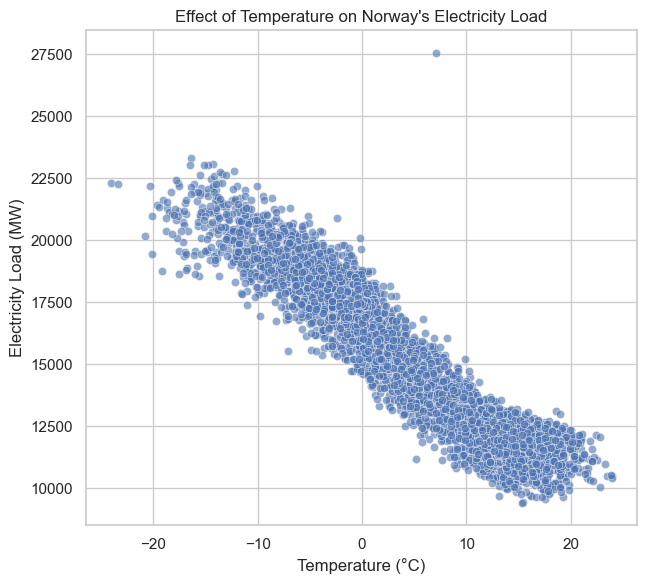

In [6]:
# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Create plots
plt.figure(figsize=(18, 6))

# Temperature vs Electricity Load in Norway
plt.subplot(1, 3, 1)
sns.scatterplot(x='Temp - Norway', y='Total Load [MW] - Norway', data=df, alpha=0.6)
plt.title('Effect of Temperature on Norway\'s Electricity Load')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Load (MW)')

plt.tight_layout()
plt.show()


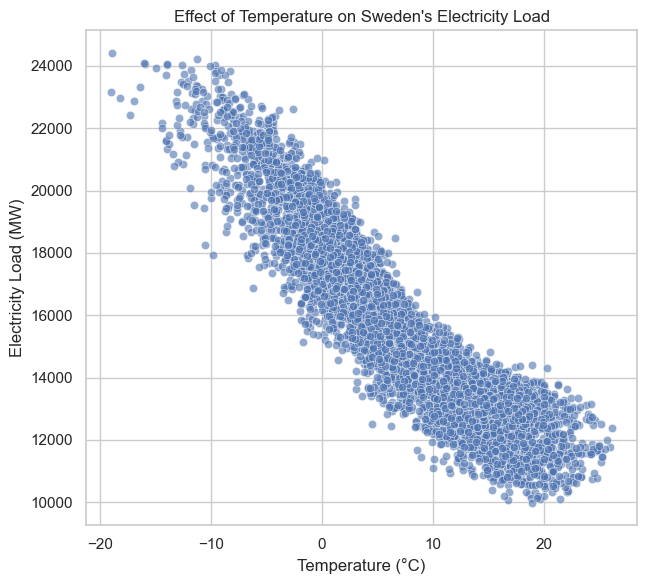

In [7]:
# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Create figure for the plots
plt.figure(figsize=(18, 6))

# Temperature effect on Sweden's electricity load
plt.subplot(1, 3, 1)
sns.scatterplot(x='Temp - Sweden', y='Total Load [MW] - Sweden', data=df, alpha=0.6)
plt.title('Effect of Temperature on Sweden\'s Electricity Load')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Load (MW)')


plt.tight_layout()
plt.show()


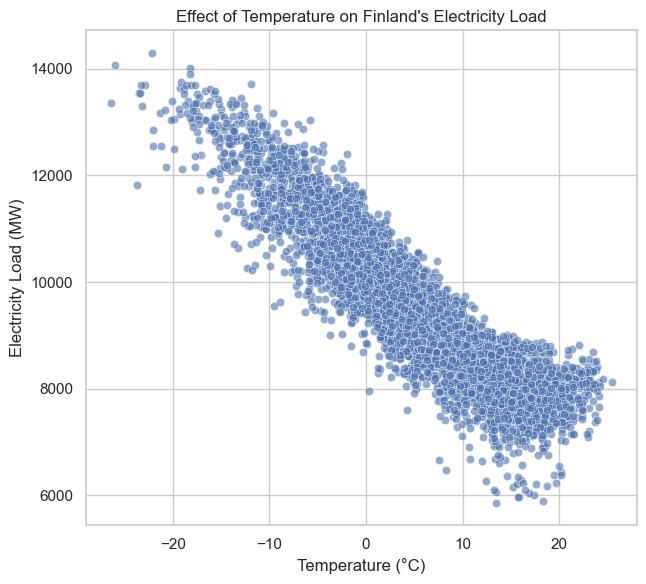

In [8]:
# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Create figure for the plots
plt.figure(figsize=(18, 6))

# Temperature effect on Finland's electricity load
plt.subplot(1, 3, 1)
sns.scatterplot(x='Temp - Finland', y='Total Load [MW] - Finland', data=df, alpha=0.6)
plt.title('Effect of Temperature on Finland\'s Electricity Load')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Load (MW)')


plt.tight_layout()


In [9]:

# Assuming 'merged_data_clean' is your DataFrame and 'Load Date' is the column with dates
# Convert 'Load Date' to datetime if it's not already
df['Load Date'] = pd.to_datetime(df['Load Date'])

# Easter Sunday dates for 2010 through 2023
easter_sundays = [
    "2010-04-04", "2011-04-24", "2012-04-08", "2013-03-31", "2014-04-20",
    "2015-04-05", "2016-03-27", "2017-04-16", "2018-04-01", "2019-04-21",
    "2020-04-12", "2021-04-04", "2022-04-17", "2023-04-09"
]

# Generate other holidays based on Easter Sundays
holidays = []
for date_str in easter_sundays:
    easter = pd.to_datetime(date_str)
    maundy_thursday = easter - timedelta(days=3)
    good_friday = easter - timedelta(days=2)
    easter_monday = easter + timedelta(days=1)
    holidays.extend([maundy_thursday, good_friday, easter, easter_monday])

# Remove holidays from the dataset
filtered_data = df[~df['Load Date'].isin(holidays)]


In [11]:
# Your merged data
# merged_data_clean['Load Date'] = pd.to_datetime(merged_data_clean['Load Date'])

# Fixed holidays for Norway, Sweden, and Finland
fixed_holidays = {
    '01-01', '05-01', '12-25', '12-26', '12-31',  # Common fixed holidays
    '05-17',  # Norway's Constitution Day
    '01-06', '06-06', '12-24',  # Additional for Sweden
    '12-06',  # Finland's Independence Day
}

# Add Midsummer Eves and Midsummer Days for Sweden and Finland from 2010 to 2023
midsummer_eves = {
    '2010': '06-25', '2011': '06-24', '2012': '06-23', '2013': '06-21', '2014': '06-20',
    '2015': '06-19', '2016': '06-24', '2017': '06-23', '2018': '06-22', '2019': '06-21',
    '2020': '06-19', '2021': '06-25', '2022': '06-24', '2023': '06-23'
}

# Generate list of all holidays including dynamic ones
all_holidays = set(pd.to_datetime(f'{year}-{day}') for year in range(2010, 2024) for day in fixed_holidays)
for year, day in midsummer_eves.items():
    all_holidays.add(pd.to_datetime(f'{year}-{day}'))  # Midsummer Eve
    all_holidays.add(pd.to_datetime(f'{year}-{day}') + timedelta(days=1))  # Midsummer Day

# Filter out the holidays from the dataset
filtered_data_complete = df[~df['Load Date'].isin(all_holidays)]

# You can then save or inspect this filtered dataset:
filtered_data_complete.head()

,Load Date,Total Load [MW] - Norway,Total Load [MW] - Sweden,Total Load [MW] - Finland,Temp - Norway,Temp - Sweden,Temp - Finland,Year
1,2010-01-02,19566,20316,12129,-15.99,-9.00,-19.03,2010
2,2010-01-03,19531,20844,11925,-14.84,-12.53,-15.06,2010
3,2010-01-04,20426,21913,12250,-12.64,-12.80,-7.33,2010
4,2010-01-05,21402,23337,12726,-19.60,-16.35,-13.74,2010
6,2010-01-07,22184,23838,13354,-20.35,-8.30,-13.58,2010


In [12]:
filtered_data_complete

,Load Date,Total Load [MW] - Norway,Total Load [MW] - Sweden,Total Load [MW] - Finland,Temp - Norway,Temp - Sweden,Temp - Finland,Year
1,2010-01-02,19566,20316,12129,-15.99,-9.00,-19.03,2010
2,2010-01-03,19531,20844,11925,-14.84,-12.53,-15.06,2010
3,2010-01-04,20426,21913,12250,-12.64,-12.80,-7.33,2010
4,2010-01-05,21402,23337,12726,-19.60,-16.35,-13.74,2010
6,2010-01-07,22184,23838,13354,-20.35,-8.30,-13.58,2010
...,...,...,...,...,...,...,...,...
5104,2023-12-23,19726,18943,10087,-13.36,-4.69,-1.57,2023
5108,2023-12-27,20125,18863,10688,-8.08,-8.57,-7.20,2023
5109,2023-12-28,20151,18044,10976,-8.64,-3.80,-4.25,2023
5110,2023-12-29,19551,17388,11279,-8.05,-0.20,-2.93,2023


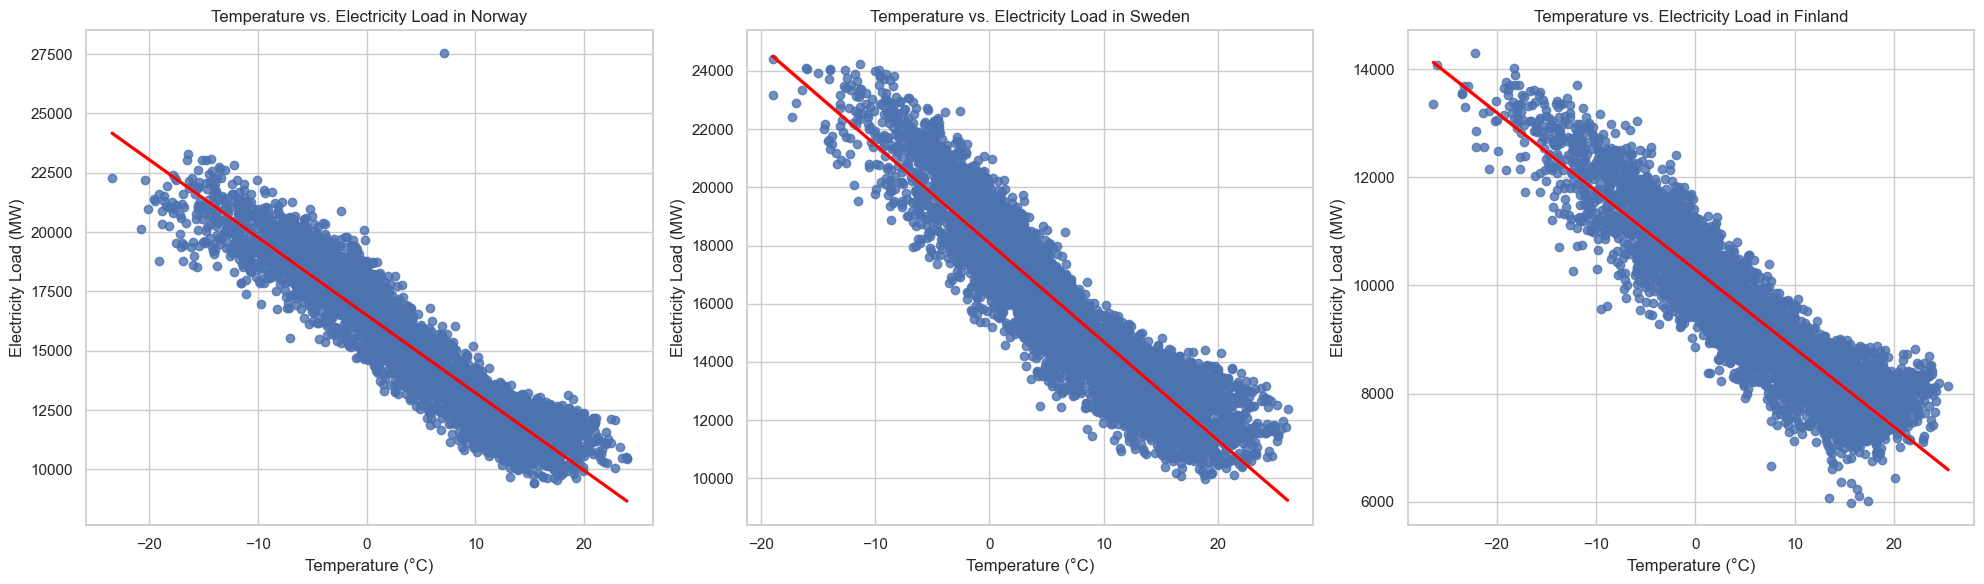

In [13]:

# Ensure your 'filtered_data_complete' DataFrame is ready and 'Load Date' is in datetime format
# Also ensure temperatures and loads are in correct format

plt.figure(figsize=[20, 6])

# Temperature vs Electricity Load in Norway
plt.subplot(1, 3, 1)
sns.regplot(x='Temp - Norway', y='Total Load [MW] - Norway', data=filtered_data_complete, line_kws={"color": "red"})
plt.title('Temperature vs. Electricity Load in Norway')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Load (MW)')

# Temperature vs Electricity Load in Sweden
plt.subplot(1, 3, 2)
sns.regplot(x='Temp - Sweden', y='Total Load [MW] - Sweden', data=filtered_data_complete, line_kws={"color": "red"})
plt.title('Temperature vs. Electricity Load in Sweden')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Load (MW)')

# Temperature vs Electricity Load in Finland
plt.subplot(1, 3, 3)
sns.regplot(x='Temp - Finland', y='Total Load [MW] - Finland', data=filtered_data_complete, line_kws={"color": "red"})
plt.title('Temperature vs. Electricity Load in Finland')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Load (MW)')

plt.tight_layout()
plt.show()

In [14]:
# Assuming the outlier has a Total Load [MW] - Norway value of 50000
filtered_data_complete = filtered_data_complete[filtered_data_complete['Total Load [MW] - Norway'] != 27000]

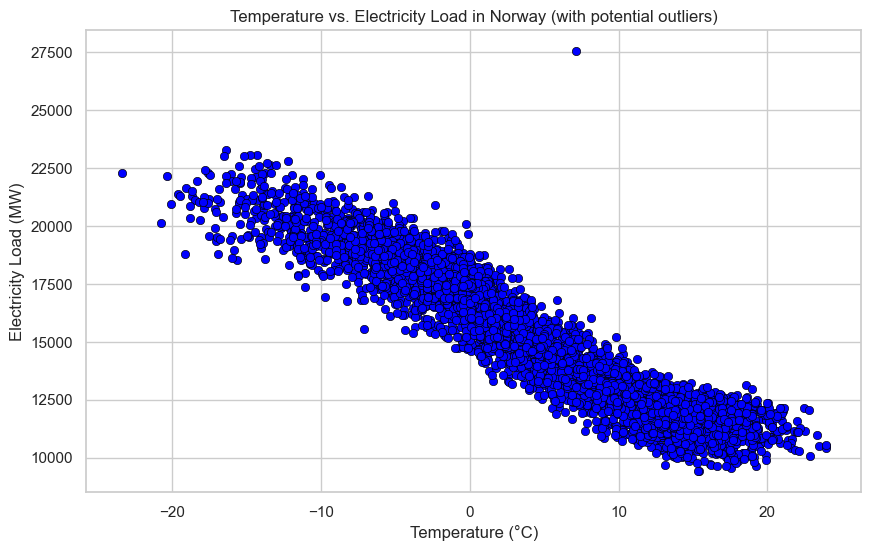

In [15]:
# Ensure your filtered_data_complete DataFrame is prepared
plt.figure(figsize=[10, 6])
sns.scatterplot(x='Temp - Norway', y='Total Load [MW] - Norway', data=filtered_data_complete, color='blue', edgecolor='black')
plt.title('Temperature vs. Electricity Load in Norway (with potential outliers)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Load (MW)')
plt.show()

In [16]:
# Remove outliers based on conditions
# Adjust the conditions to suit the outlier's characteristics
condition = ((filtered_data_complete['Temp - Norway'] >= 6) & 
             (filtered_data_complete['Total Load [MW] - Norway'] > 27000))  # Just an example, adjust accordingly
cleaned_data = filtered_data_complete[~condition]

# Now cleaned_data should be free from the specific outliers
# You can check the first few rows or the shape of the DataFrame to confirm
cleaned_data

,Load Date,Total Load [MW] - Norway,Total Load [MW] - Sweden,Total Load [MW] - Finland,Temp - Norway,Temp - Sweden,Temp - Finland,Year
1,2010-01-02,19566,20316,12129,-15.99,-9.00,-19.03,2010
2,2010-01-03,19531,20844,11925,-14.84,-12.53,-15.06,2010
3,2010-01-04,20426,21913,12250,-12.64,-12.80,-7.33,2010
4,2010-01-05,21402,23337,12726,-19.60,-16.35,-13.74,2010
6,2010-01-07,22184,23838,13354,-20.35,-8.30,-13.58,2010
...,...,...,...,...,...,...,...,...
5104,2023-12-23,19726,18943,10087,-13.36,-4.69,-1.57,2023
5108,2023-12-27,20125,18863,10688,-8.08,-8.57,-7.20,2023
5109,2023-12-28,20151,18044,10976,-8.64,-3.80,-4.25,2023
5110,2023-12-29,19551,17388,11279,-8.05,-0.20,-2.93,2023


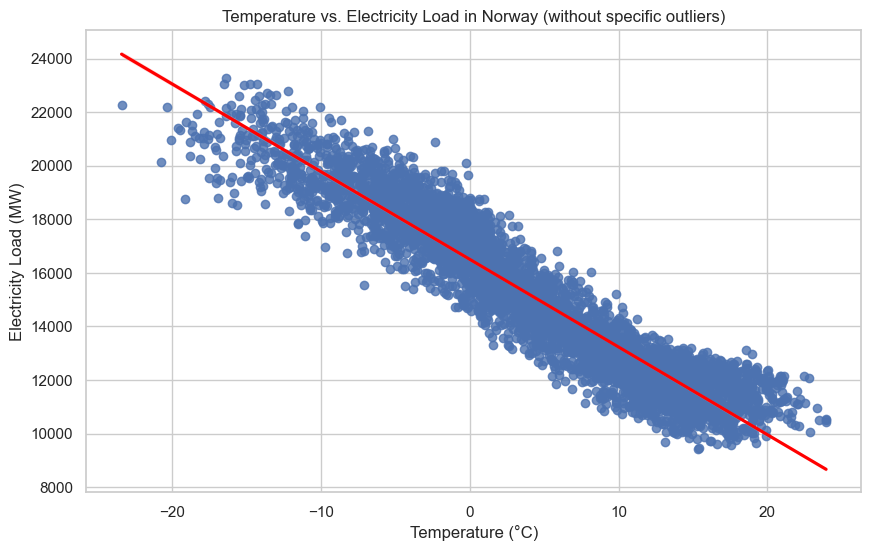

In [17]:
plt.figure(figsize=[10, 6])
sns.regplot(x='Temp - Norway', y='Total Load [MW] - Norway', data=cleaned_data, line_kws={"color": "red"})
plt.title('Temperature vs. Electricity Load in Norway (without specific outliers)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Load (MW)')
plt.show()

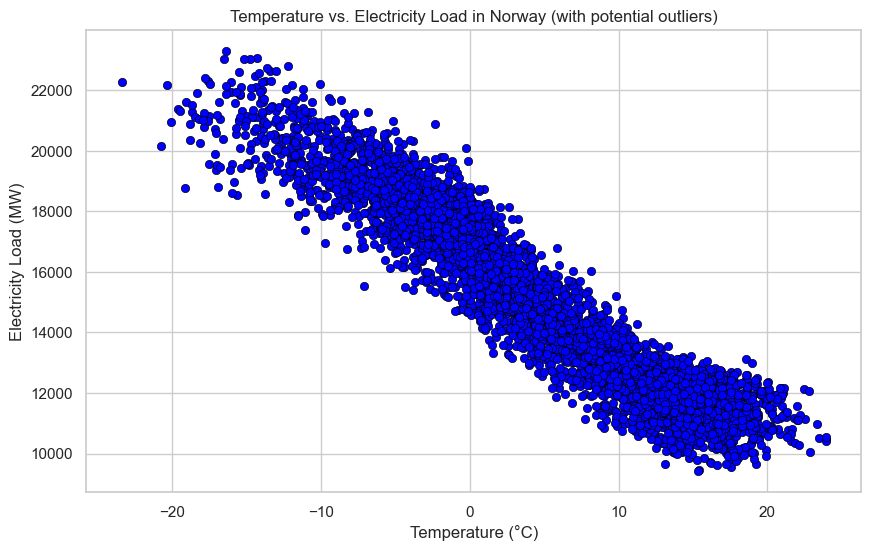

In [18]:
plt.figure(figsize=[10, 6])
sns.scatterplot(x='Temp - Norway', y='Total Load [MW] - Norway', data=cleaned_data, color='blue', edgecolor='black')
plt.title('Temperature vs. Electricity Load in Norway (with potential outliers)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Electricity Load (MW)')
plt.show()

In [19]:
# Define the conditions that were used to identify the outlier
condition = ((filtered_data_complete['Temp - Norway'] > 7) & 
             (filtered_data_complete['Total Load [MW] - Norway'] > 27000))

# Filter the original dataset based on these conditions to find the outlier(s)
outliers = filtered_data_complete[condition]

# Display the dates and other relevant details of the identified outliers
print(outliers[['Load Date', 'Temp - Norway', 'Total Load [MW] - Norway']])

      Load Date  Temp - Norway  Total Load [MW] - Norway
1973 2015-05-28           7.11                     27553


In [20]:
# Ensure 'cleaned_data' is your DataFrame after removal of outliers
cleaned_data.to_csv('nordic_data_df.csv', index=False)

In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it's already indexed by date
# If not, set it like: df.index = pd.to_datetime(df['YourDateColumn'])

# Check stationarity and decide on differencing
# You can plot your data and use ADF test, for example
# plot_acf(df['Total Load [MW] - Norway'].diff().dropna())
# plot_pacf(df['Total Load [MW] - Norway'].diff().dropna())

# Determine the (p, d, q) for ARIMA and build ARIMAX model
# This is an example; you'll need to identify the best parameters
p = 1  # Replace with your chosen p value
d = 1  # Replace with your chosen d value (usually the order of differencing)
q = 1  # Replace with your chosen q value
model = SARIMAX(df['Total Load [MW] - Norway'], exog=df[['Temp - Norway']], order=(p, d, q))

# Fit the model
results = model.fit()

# Summary of the model
print(results.summary())

# Plot diagnostics to investigate any unusual behavior
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecasting future values
# For forecasting, you need to provide future values of the temperature
# Replace 'future_temps' with your future temperature values, ensure it's in the correct shape
# forecast = results.get_forecast(steps=10, exog=future_temps)
# forecast_predicted_mean = forecast.predicted_mean


NameError: name 'df' is not defined